<a href="https://colab.research.google.com/github/Haadhi-Mohammed/Projects/blob/main/CustomerSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pyspark

In [ ]:
# installing PySpark

!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=508c071dc8a663498b265e2d0544f4fa0601991dccb8fc0f3762ee4402bab96d
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local[*]")\
        .appName("Colab")\
        .config('spark.ui.port', '4040')\
        .getOrCreate()
print(spark)

In [ ]:
# Installing Necessary Packages

from pyspark.sql.functions import col, isnan, when, count
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, PCA
from pyspark.ml import Pipeline

from pyspark.ml.feature import PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Original Dataset

In [ ]:
# Load dataset
df = spark.read.csv("/content/Cleaned_CusSeg.csv", header=True, inferSchema=True)
df.show(5)

+----+---+----------+--------------+------+-------+--------+-----------+-------+-----+------+------------+------------+-------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+--------+
|  ID|Age| Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|Wines|Fruits|MeatProducts|FishProducts|SweetProducts|GoldProducts|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Response|
+----+---+----------+--------------+------+-------+--------+-----------+-------+-----+------+------------+------------+-------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+--------+
|5524| 57|Graduation|        Single| 581

In [ ]:
# Print the schema of the DataFrame
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Education: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Kidhome: integer (nullable = true)
 |-- Teenhome: integer (nullable = true)
 |-- Dt_Customer: integer (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- Wines: integer (nullable = true)
 |-- Fruits: integer (nullable = true)
 |-- MeatProducts: integer (nullable = true)
 |-- FishProducts: integer (nullable = true)
 |-- SweetProducts: integer (nullable = true)
 |-- GoldProducts: integer (nullable = true)
 |-- NumDealsPurchases: integer (nullable = true)
 |-- NumWebPurchases: integer (nullable = true)
 |-- NumCatalogPurchases: integer (nullable = true)
 |-- NumStorePurchases: integer (nullable = true)
 |-- NumWebVisitsMonth: integer (nullable = true)
 |-- AcceptedCmp3: integer (nullable = true)
 |-- AcceptedCmp4: integer (nullable = true)
 |-- AcceptedCmp5: integer (nullabl

In [ ]:
# Check for null values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+---+---------+--------------+------+-------+--------+-----------+-------+-----+------+------------+------------+-------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+--------+
| ID|Age|Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|Wines|Fruits|MeatProducts|FishProducts|SweetProducts|GoldProducts|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Response|
+---+---+---------+--------------+------+-------+--------+-----------+-------+-----+------+------------+------------+-------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+--------+
|  0|  0|        0|             0|     0|     

In [ ]:
# Convert categorical columns to numerical using StringIndexer and OneHotEncoder
categorical_columns = ['Education', 'Marital_Status']
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_columns]
encoders = [OneHotEncoder(inputCols=[col + "_index"], outputCols=[col + "_vec"]) for col in categorical_columns]

In [ ]:
# Define the feature columns
numeric_columns = ['Age', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency',
                   'Wines', 'Fruits', 'MeatProducts', 'FishProducts', 'SweetProducts',
                   'GoldProducts', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
                   'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4',
                   'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']

In [ ]:
# Assemble features into a single vector
assembler = VectorAssembler(inputCols=[col + "_vec" for col in categorical_columns] + numeric_columns,
                            outputCol="features")

# Standardize the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

In [ ]:
# Create the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler])

# Fit and transform the data
model = pipeline.fit(df)
df_transformed = model.transform(df)

# Pricipal Componant Analysis

In [ ]:
# Apply PCA
pca = PCA(k=len(numeric_columns) + len(categorical_columns), inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(df_transformed)

# Extract explained variance
explained_variance = pca_model.explainedVariance.toArray()

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Determine the number of components to keep to explain 95% of the variance
threshold = 0.90
num_components = np.where(cumulative_variance >= threshold)[0][0] + 1

print(f"Number of components to retain {threshold*100}% variance: {num_components}")

Number of components to retain 90.0% variance: 21


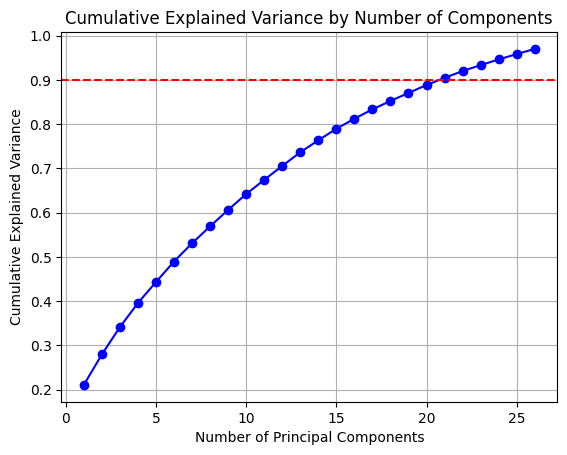

In [ ]:
# Plot cumulative explained variance
plt.figure()
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'o-', color='b')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.grid(True)
plt.show()

In [ ]:
# Apply PCA with 21 components
pca = PCA(k=21, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(df_transformed)
df_pca = pca_model.transform(df_transformed)

# K-Means Clustering

In [ ]:
for k in range(2, 20):
    kmeans = KMeans(k=k, seed=1, featuresCol="pca_features", predictionCol="cluster")
    kmeans_model = kmeans.fit(df_pca)
    df_clusters = kmeans_model.transform(df_pca)
    evaluator = ClusteringEvaluator(predictionCol='cluster', featuresCol='pca_features', metricName='silhouette')
    silhouette_score = evaluator.evaluate(df_clusters)
    print(f'Silhouette Score for k={k}: {silhouette_score}')

Silhouette Score for k=2: 0.3292707148738423
Silhouette Score for k=3: 0.33916962913549553
Silhouette Score for k=4: 0.22228086143399467
Silhouette Score for k=5: 0.23437840352882616
Silhouette Score for k=6: 0.24289909487283445
Silhouette Score for k=7: 0.15771609718939686
Silhouette Score for k=8: 0.15929187270698264
Silhouette Score for k=9: 0.16149693063315124
Silhouette Score for k=10: 0.20368147296022107
Silhouette Score for k=11: 0.15090103033120256
Silhouette Score for k=12: 0.179876030517097
Silhouette Score for k=13: 0.17274128313794637
Silhouette Score for k=14: 0.18907999568286896
Silhouette Score for k=15: 0.2001926128724316
Silhouette Score for k=16: 0.18788936470344544
Silhouette Score for k=17: 0.18758942209242965
Silhouette Score for k=18: 0.2078696838199391
Silhouette Score for k=19: 0.19872070555458743


In [ ]:
# Perform K-Means clustering with k=3
k = 2
kmeans = KMeans(k=k, seed=1, featuresCol="pca_features", predictionCol="cluster")
kmeans_model = kmeans.fit(df_pca)
df_clusters = kmeans_model.transform(df_pca)

# Show the results
df_clusters.select("Id", "cluster").show(truncate=False)

+----+-------+
|Id  |cluster|
+----+-------+
|5524|0      |
|2174|1      |
|4141|0      |
|6182|1      |
|5324|1      |
|7446|0      |
|965 |0      |
|6177|1      |
|4855|1      |
|5899|1      |
|387 |1      |
|2125|0      |
|8180|1      |
|2569|1      |
|2114|0      |
|9736|1      |
|4939|1      |
|6565|0      |
|2278|1      |
|9360|1      |
+----+-------+
only showing top 20 rows



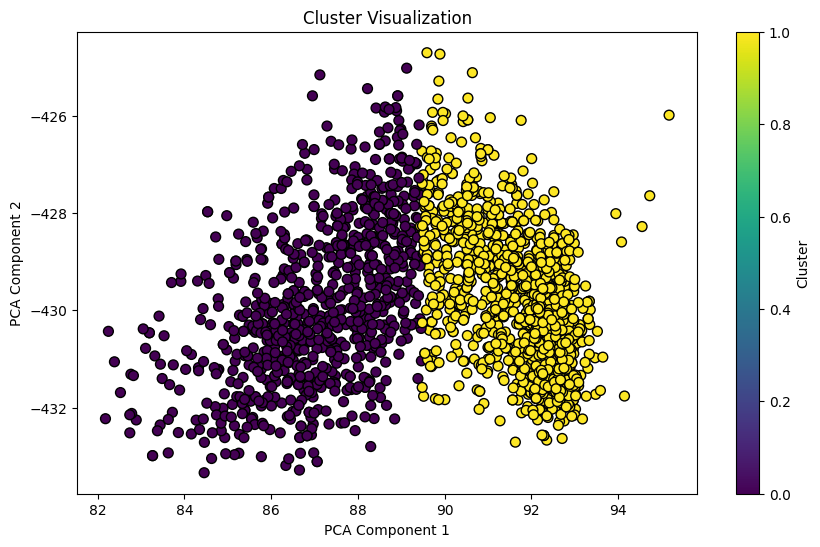

In [ ]:
# Convert Spark DataFrame to Pandas for visualization
pdf = df_clusters.select('pca_features', 'cluster').toPandas()
pdf['pca_x'] = pdf['pca_features'].apply(lambda x: x[0])
pdf['pca_y'] = pdf['pca_features'].apply(lambda x: x[1])

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(pdf['pca_x'], pdf['pca_y'], c=pdf['cluster'], cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Cluster Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
# Export clustering results to CSV for visualization in tools like Tableau
df_clusters.select("Id", "cluster").write.csv("/content/clusters1.csv", header=True)

In [ ]:
from pyspark.sql.functions import count

df_clusters.groupBy('cluster').count().show()

+-------+-----+
|cluster|count|
+-------+-----+
|      1| 1329|
|      0|  875|
+-------+-----+



In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, DoubleType
import pandas as pd

# Assuming df_clusters is your DataFrame with the 'pca_features' column

# Define a UDF to extract components from the Vector
def extract_pca_components(v):
    return v.toArray().tolist()

extract_pca_components_udf = udf(extract_pca_components, ArrayType(DoubleType()))

# Apply the UDF to create an array column
df_clusters = df_clusters.withColumn("pca_array", extract_pca_components_udf(col("pca_features")))

# Split the array column into separate columns
for i in range(num_components):  # assuming num_components is defined
    df_clusters = df_clusters.withColumn(f"PC{i+1}", col("pca_array")[i])

# Drop the temporary array column
df_clusters = df_clusters.drop("pca_array")

In [ ]:
# List of columns to keep
columns_to_keep = [
    'ID', 'Age', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
    'Dt_Customer', 'Recency', 'Wines', 'Fruits', 'MeatProducts', 'FishProducts',
    'SweetProducts', 'GoldProducts', 'NumDealsPurchases', 'NumWebPurchases',
    'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
    'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain',
    'Response', 'cluster', 'PC1', 'PC2'
]

# Select the necessary columns
df_final = df_clusters.select(columns_to_keep)

# Save the DataFrame to CSV
df_final.toPandas().to_csv('clustered_data_with_selected_columns.csv', index=False)


In [ ]:
df_final.show()

+----+---+----------+--------------+------+-------+--------+-----------+-------+-----+------+------------+------------+-------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+--------+-------+-----------------+-------------------+
|  ID|Age| Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|Wines|Fruits|MeatProducts|FishProducts|SweetProducts|GoldProducts|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Response|cluster|              PC1|                PC2|
+----+---+----------+--------------+------+-------+--------+-----------+-------+-----+------+------------+------------+-------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------

In [ ]:
# Get cluster centers
cluster_centers = kmeans_model.clusterCenters()

# Print cluster centers to analyze
for idx, center in enumerate(cluster_centers):
    print(f"Cluster {idx} center: {center}")

Cluster 0 center: [  87.08886987 -429.84645359  -82.46450224 1118.02034922   43.07010331
 -717.7993489   361.17319283   52.16321256  519.94649723  -16.49833623
 -757.65082052 -146.50520123 -975.5622274  1281.66536347  759.27713335
 -298.5919769  -513.8319033   176.11779785 -668.01631057 -510.32259108
 -688.18675105]
Cluster 1 center: [  91.75772153 -429.88318931  -82.66330573 1117.99334586   43.05682896
 -717.89179179  361.12096981   52.22990572  519.99248117  -16.54155555
 -757.66829965 -146.48956314 -975.60811777 1281.73275237  759.11913111
 -298.5814216  -513.84683404  176.1089439  -668.04202887 -510.29391962
 -688.13141932]


In [ ]:
cluster_0_center_pca = np.array([87.08886987, -429.84645359, -82.46450224, 1118.02034922, 43.07010331, -717.7993489, 361.17319283, 52.16321256, 519.94649723, -16.49833623, -757.65082052, -146.50520123, -975.5622274, 1281.66536347, 759.27713335, -298.5919769, -513.8319033, 176.11779785, -668.01631057, -510.32259108, -688.18675105])
cluster_1_center_pca = np.array([91.75772153, -429.88318931, -82.66330573, 1117.99334586, 43.05682896, -717.89179179, 361.12096981, 52.22990572, 519.99248117, -16.54155555, -757.66829965, -146.48956314, -975.60811777, 1281.73275237, 759.11913111, -298.5814216, -513.84683404, 176.1089439, -668.04202887, -510.29391962, -688.13141932])

In [ ]:
df_pca_pd = df_final.toPandas()


In [ ]:
explained_variance = pca_model.explainedVariance
print("Explained Variance Ratios:", explained_variance)


Explained Variance Ratios: [0.21048017984531084,0.06890821946702862,0.0617062109804791,0.054528830286003124,0.047499435572708935,0.046345157615207334,0.041228896815527306,0.03822257687753689,0.03725778101074818,0.03566601146606471,0.0322055361344462,0.03143317420389704,0.030911174874487593,0.02712505763906371,0.025893934972355044,0.022855242799258737,0.021156323184500038,0.01898623495725429,0.018168446522286743,0.01783746156287887,0.01615535049100201]


In [ ]:
print(df_pca_pd.columns)


Index(['ID', 'Age', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'Wines', 'Fruits', 'MeatProducts',
       'FishProducts', 'SweetProducts', 'GoldProducts', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'cluster',
       'PC1', 'PC2'],
      dtype='object')


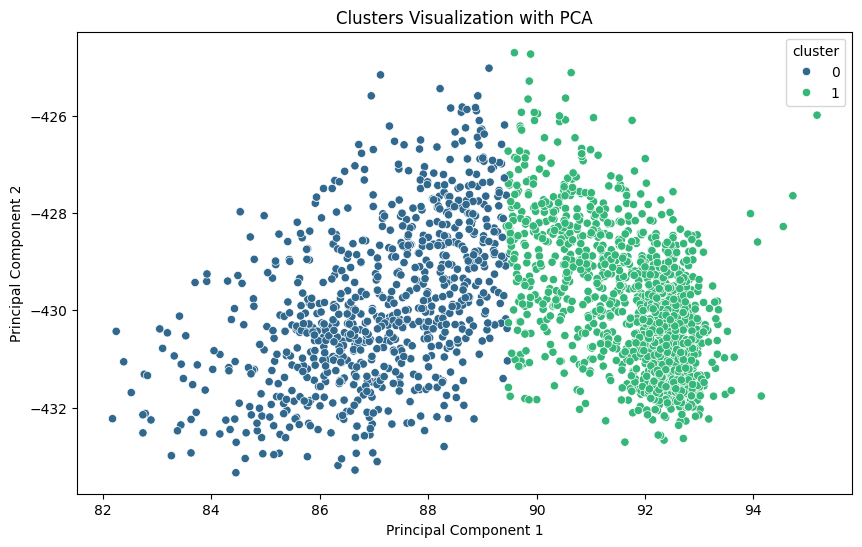

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=df_pca_pd, palette='viridis')
plt.title('Clusters Visualization with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
cluster_0 = df_pca_pd[df_pca_pd['cluster'] == 0]
cluster_1 = df_pca_pd[df_pca_pd['cluster'] == 1]

print("Cluster 0 PCA Features Description:")
print(cluster_0.describe())

print("\nCluster 1 PCA Features Description:")
print(cluster_1.describe())


Cluster 0 PCA Features Description:
                 ID         Age         Income     Kidhome    Teenhome  \
count    875.000000  875.000000     875.000000  875.000000  875.000000   
mean    5617.974857   46.900571   71647.654857    0.061714    0.427429   
std     3234.706332   12.216504   12926.577289    0.245480    0.532837   
min        0.000000   19.000000    2447.000000    0.000000    0.000000   
25%     2878.500000   38.000000   63929.000000    0.000000    0.000000   
50%     5524.000000   47.000000   71613.000000    0.000000    0.000000   
75%     8572.000000   57.000000   79780.500000    0.000000    1.000000   
max    11112.000000   73.000000  160803.000000    2.000000    2.000000   

       Dt_Customer     Recency        Wines      Fruits  MeatProducts  ...  \
count   875.000000  875.000000   875.000000  875.000000    875.000000  ...   
mean   2012.962286   49.406857   609.779429   56.148571    363.853714  ...   
std       0.683037   28.862674   314.584311   48.330606    245.